# 7-7. 프로젝트: 인물 모드 문제점 찾기

만들면서 뭔가 이상한 점이 느껴지지 않으셨나요? 프로젝트를 통해 찾아봅시다.

## Step 1. 인물모드 직접 해 보기

- 여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.
- 인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.
- 배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요?





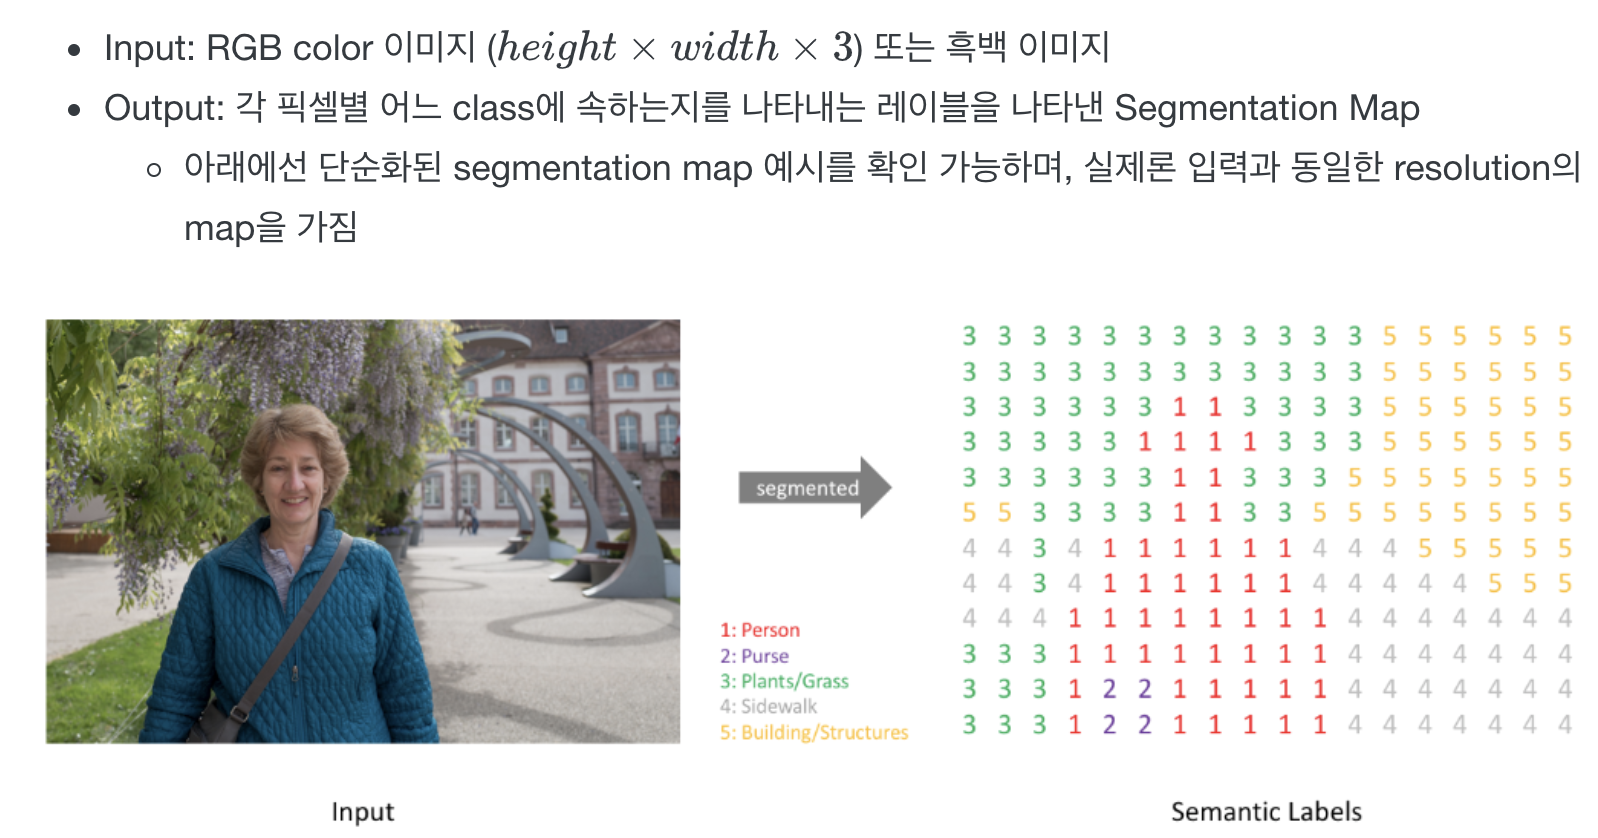

## 필요한 라이브러리 import

In [16]:
!pip3 install pixellib

import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

  Using cached Pillow-9.0.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.3 MB)
  Attempting uninstall: pillow
    Found existing installation: Pillow 4.1.1
    Uninstalling Pillow-4.1.1:
      Successfully uninstalled Pillow-4.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


  Using cached Pillow-4.1.1-cp37-cp37m-linux_x86_64.whl
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.0.0
    Uninstalling Pillow-9.0.0:
      Successfully uninstalled Pillow-9.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires pillow!=8.3.0,>=5.3.0, but you have pillow 4.1.1 which is incompatible.
scikit-image 0.18.3 requires pillow!=7.1.0,!=7.1.1,>=4.3.0, but you have pillow 4.1.1 which is incompatible.
sahi 0.8.22 requires pillow>=8.2.0, but you have pillow 4.1.1 which is incompatible.
bokeh 2.3.3 requires pillow>=7.1.0, but you have pillow 4.1.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


## 1.웹툰 캐릭터로 시도

### 1-1) 세그멘테이션으로 사람 분리하기

(260, 260, 3)


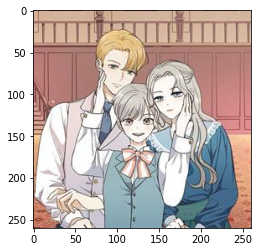

In [17]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path_1 = '/content/drive/MyDrive/아이펠/풀잎스쿨/data/human_segmentation/images/1.jpeg'
img_orig_1 = cv2.imread(img_path_1) 

print(img_orig_1.shape)
plt.imshow(cv2.cvtColor(img_orig_1, cv2.COLOR_BGR2RGB))
plt.show()

그다음 다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성합니다.

In [18]:
model = semantic_segmentation()
model.load_pascalvoc_model('/content/drive/MyDrive/아이펠/풀잎스쿨/data/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

In [19]:
# 모델에 이미지를 입력
segvalues, output = model.segmentAsPascalvoc(img_path_1)

`segmentAsPascalvoc`라는 함수 이름에서 세그멘테이션 모델에 대한 힌트를 얻을 수 있는데요. PASCAL VOC 데이터로 학습된 모델을 이용한다는 의미입니다. 모델마다 학습시킨 데이터에 따라 결괏값이 달라지므로 어떤 데이터를 학습시켰는지 확인하는 것은 매우 중요합니다.

- [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/)

PASCAL VOC 데이터의 라벨 종류는 아래와 같습니다.

In [20]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

background를 제외하면 20개의 클래스가 있습니다. 따라서 `20` 의 의미는 `tv` 가 되겠네요! 0부터 시작하니까요.

우리는 이 중 사람(`person`) 라벨, 즉 `15`를 가진 영역만 검출해 내고 싶습니다. 이제 사람만 어떻게 추출할 수 있을지 알아봅시다.

아까 모델에서 나온 출력값을 살짝 살펴볼게요.



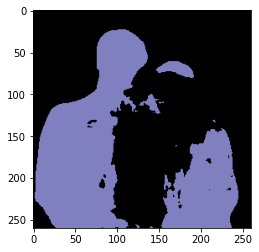

In [21]:
plt.imshow(output)
plt.show()

In [22]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [23]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [24]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

`PixelLib`에 따르면 위와 같은 색을 사용했다고 하네요. 그럼 사람을 나타내는 `15`번째 색상은 무엇일까요?

In [25]:
colormap[15]

array([192, 128, 128])

사람 외에도 다른 물체를 찾아내고 싶다면 `colormap[class_id]`처럼 찾아낼 수 있을 것이다.

여기서 주의할 것은 `output` 이미지가 BGR 순서로 채널 배치가 되어 있다는 점이다. `colormap`은 RGB 순서이므로 아래와 같이 바꿔준다.

In [26]:
seg_color = (128,128,192)

이제 `seg_color`로만 이루어진 마스크를 만들어 본다.

(260, 260)


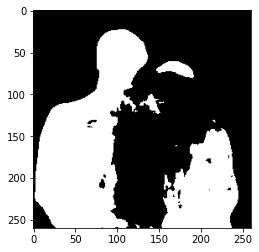

In [27]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

3채널 가졌던 원본과는 다르게 채널 정보가 사라짐.

이제 아래처럼 물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열이 된다.

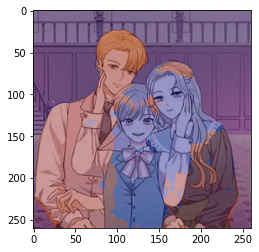

In [28]:
img_show = img_orig_1.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 1-2) 배경 흐리게 하기

blur() 함수를 이용하여 배경을 흐리게 만든다.

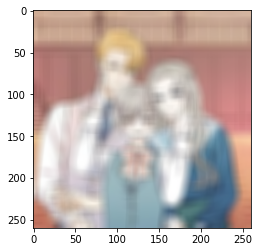

In [29]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur_1 = cv2.blur(img_orig_1, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur_1, cv2.COLOR_BGR2RGB))
plt.show()

흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출

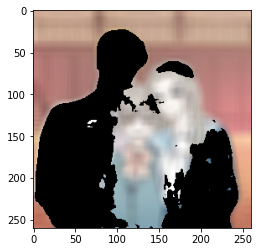

In [31]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur_1, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 1-3) 흐린 배경과 원본 영상 합성

이제 배경 영상과 사람 영상을 합치기만 하면 되겠죠?

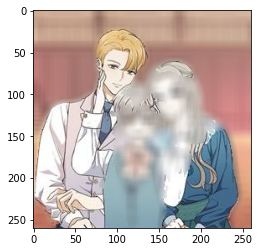

In [33]:
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용
# np.where(조건, 참일때, 거짓일때)
img_concat = np.where(img_mask_color==255, img_orig_1, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

- 웹툰 캐릭터들은 사람으로 인식을 못할줄 알았는데... <u>아빠만 사람취급함...</u> 

## 2.TV 프로그램 포스터로 시도 (인물이 가까이 있는 사진)

### 2-1) 세그멘테이션으로 사람 분리하기

(855, 600, 3)


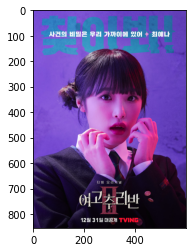

In [34]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path2 = '/content/drive/MyDrive/아이펠/풀잎스쿨/data/human_segmentation/images/예나.jpg'
img_orig2 = cv2.imread(img_path2) 

print(img_orig2.shape)
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
plt.show()

그다음 다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성합니다.

In [35]:
# 모델에 이미지를 입력
segvalues2, output2 = model.segmentAsPascalvoc(img_path2)

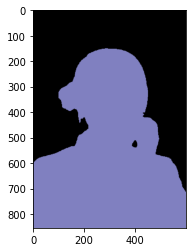

In [36]:
plt.imshow(output2)
plt.show()

In [37]:
segvalues2

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]])}

In [38]:
for class_id in segvalues2['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [39]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap2 = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap2[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap2[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

`PixelLib`에 따르면 위와 같은 색을 사용했다고 하네요. 그럼 사람을 나타내는 `15`번째 색상은 무엇일까요?

In [40]:
colormap2[15]

array([192, 128, 128])

사람 외에도 다른 물체를 찾아내고 싶다면 `colormap[class_id]`처럼 찾아낼 수 있을 것이다.

여기서 주의할 것은 `output` 이미지가 BGR 순서로 채널 배치가 되어 있다는 점이다. `colormap`은 RGB 순서이므로 아래와 같이 바꿔준다.

In [41]:
seg_color = (128, 128, 192)

이제 `seg_color`로만 이루어진 마스크를 만들어 본다.

(855, 600)


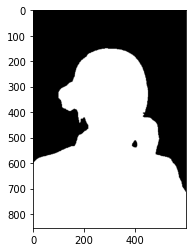

In [45]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map2 = np.all(output2==seg_color, axis=-1)
print(seg_map2.shape)
plt.imshow(seg_map2, cmap='gray')
plt.show()

3채널 가졌던 원본과는 다르게 채널 정보가 사라짐.

이제 아래처럼 물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열이 된다.

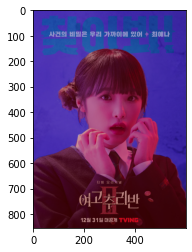

In [46]:
img_show2 = img_orig2.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask2 = seg_map2.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask2 = cv2.applyColorMap(img_mask2, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show2 = cv2.addWeighted(img_show2, 0.6, color_mask2, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB))
plt.show()

### 2-2) 배경 흐리게 하기

blur() 함수를 이용하여 배경을 흐리게 만든다.

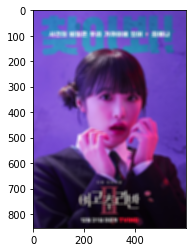

In [47]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur2 = cv2.blur(img_orig2, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur2, cv2.COLOR_BGR2RGB))
plt.show()

흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출

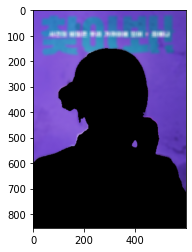

In [48]:
img_mask_color2 = cv2.cvtColor(img_mask2, cv2.COLOR_GRAY2BGR)
img_bg_mask2 = cv2.bitwise_not(img_mask_color2)
img_bg_blur2 = cv2.bitwise_and(img_orig_blur2, img_bg_mask2)
plt.imshow(cv2.cvtColor(img_bg_blur2, cv2.COLOR_BGR2RGB))
plt.show()

### 2-3) 흐린 배경과 원본 영상 합성

이제 배경 영상과 사람 영상을 합치기만 하면 되겠죠?

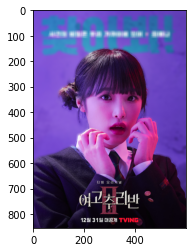

In [49]:
# np.where(조건, 참일때, 거짓일때)
img_concat2 = np.where(img_mask_color2==255, img_orig2, img_bg_blur2)
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
plt.show()

## 3.인물이 멀리 나오는 사진

### 3-1) 세그멘테이션으로 사람 분리하기

(592, 891, 3)


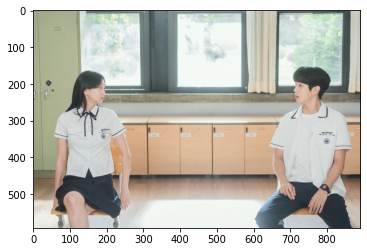

In [50]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = '/content/drive/MyDrive/아이펠/풀잎스쿨/data/human_segmentation/images/그해 우리는.jpg'
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

그다음 다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성합니다.

In [51]:
# 모델에 이미지를 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

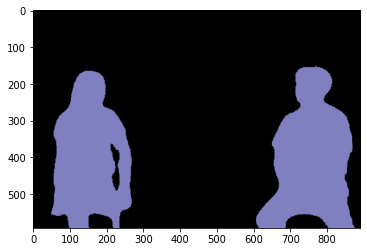

In [52]:
plt.imshow(output)
plt.show()

In [53]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [54]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [55]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

`PixelLib`에 따르면 위와 같은 색을 사용했다고 하네요. 그럼 사람을 나타내는 `15`번째 색상은 무엇일까요?

In [56]:
colormap[15]

array([192, 128, 128])

사람 외에도 다른 물체를 찾아내고 싶다면 `colormap[class_id]`처럼 찾아낼 수 있을 것이다.

여기서 주의할 것은 `output` 이미지가 BGR 순서로 채널 배치가 되어 있다는 점이다. `colormap`은 RGB 순서이므로 아래와 같이 바꿔준다.

In [57]:
seg_color = (128, 128, 192)

이제 `seg_color`로만 이루어진 마스크를 만들어 본다.

(592, 891)


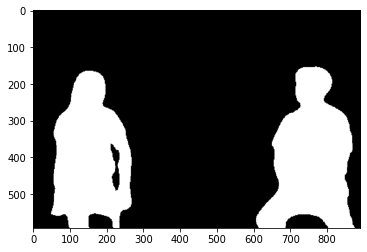

In [58]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

3채널 가졌던 원본과는 다르게 채널 정보가 사라짐.

이제 아래처럼 물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열이 된다.

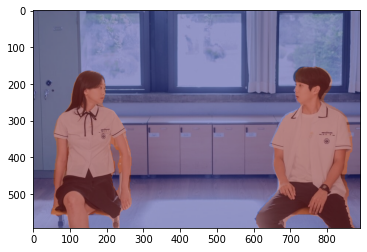

In [59]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 3-2) 배경 흐리게 하기

blur() 함수를 이용하여 배경을 흐리게 만든다.

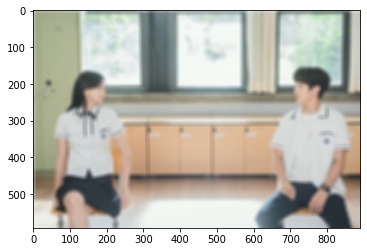

In [60]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출

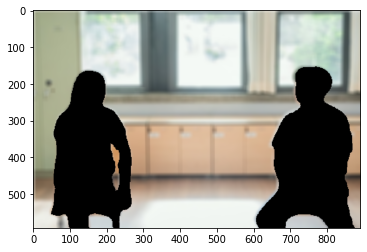

In [61]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 3-3) 흐린 배경과 원본 영상 합성

이제 배경 영상과 사람 영상을 합치기만 하면 되겠죠?

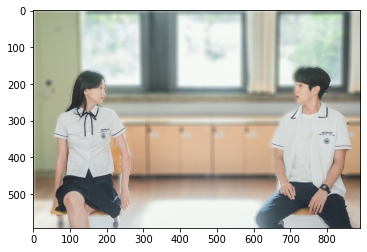

In [62]:
# np.where(조건, 참일때, 거짓일때)
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 4.쿼카

### 4-1) 세그멘테이션으로 쿼카 분리하기

(411, 730, 3)


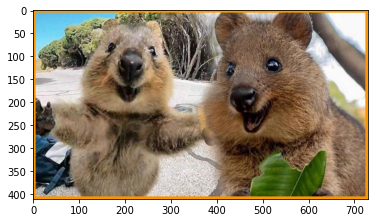

In [63]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = '/content/drive/MyDrive/아이펠/풀잎스쿨/data/human_segmentation/images/쿼카.jpg'
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

그다음 다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성합니다.

In [64]:
# 모델에 이미지를 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

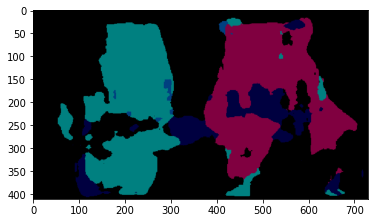

In [65]:
plt.imshow(output)
plt.show()

In [66]:
segvalues

{'class_ids': array([ 0,  3,  8, 12, 17]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [67]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bird
cat
dog
sheep


In [68]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [69]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

`PixelLib`에 따르면 위와 같은 색을 사용했다고 하네요. 그럼 쿼카를 나타내는 `3`번째 색상은 무엇일까요?

In [70]:
colormap[3]

array([128, 128,   0])

사람 외에도 다른 물체를 찾아내고 싶다면 `colormap[class_id]`처럼 찾아낼 수 있을 것이다.

여기서 주의할 것은 `output` 이미지가 BGR 순서로 채널 배치가 되어 있다는 점이다. `colormap`은 RGB 순서이므로 아래와 같이 바꿔준다.

In [71]:
seg_color = (0, 128, 128)

이제 `seg_color`로만 이루어진 마스크를 만들어 본다.

(411, 730)


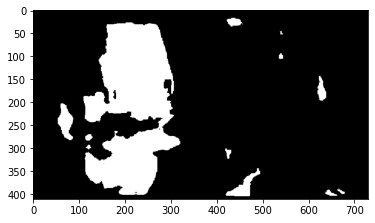

In [72]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

3채널 가졌던 원본과는 다르게 채널 정보가 사라짐.

이제 아래처럼 물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열이 된다.

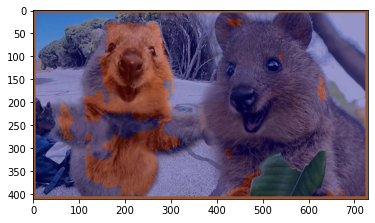

In [73]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 4-2) 배경 흐리게 하기

blur() 함수를 이용하여 배경을 흐리게 만든다.

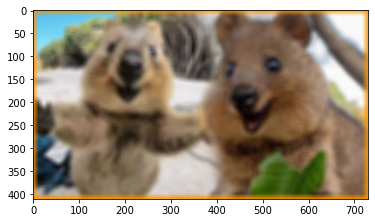

In [74]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출

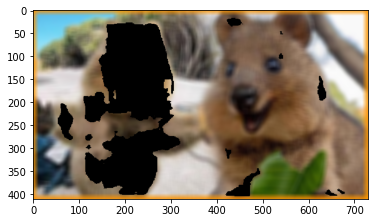

In [75]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 4-3) 흐린 배경과 원본 영상 합성

이제 배경 영상과 사람 영상을 합치기만 하면 되겠죠?

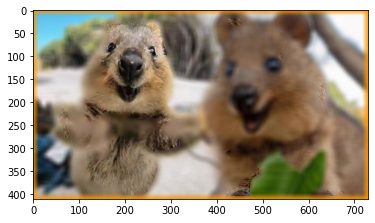

In [76]:
# np.where(조건, 참일때, 거짓일때)
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## Step 2. 사진에서 문제점 찾기

그러나 여러분들의 사진에는 무언가 문제점이 있을 것입니다.

아래 사진에도 문제점이 몇 가지 있었습니다. 예를 들어 뒤에 걸린 옷이 인물 영역에 포함되어 blur되지 않고 나온다던가 하는 경우입니다. ㅠㅠ 그 외 다른 문제들이 눈에 띄시나요? 아래 사진에는 이상한 점이 최소 2개 이상 더 있습니다. 어떤 문제가 있는지 찾아서 아래 사진처럼 표시해 봅시다.

추가로 여러분이 만들어 낸 인물 모드 사진 중 하나에서도 이상한 위치를 찾아 아래 사진처럼 표시해 봅시다. 표시한 이미지들을 jupyter notebook에 포함하여 제출해 주세요.

![](https://d3s0tskafalll9.cloudfront.net/media/images/E-14-13.max-800x600.png)

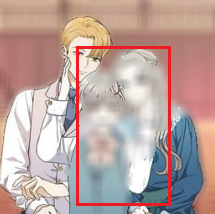
- 다른 실제 인물사진은 비교적 잘 검출되는데, ***웹툰사진***은 <u>세 사람 중 한명만 사람으로 인식</u>해서 이번 프로젝트의 타깃으로 삼았다.
- 아예 모두 인식을 못했으면 그러려니 했을텐데, 한사람은 정확히 검출했기때문에 세 사람 다 사람으로 인식되도록 해보고 싶어졌다.

## Step 3. 해결 방법을 제안해 보기



### 시도해 본 방법 1) 샤프닝 '라플라스 필터' 적용하기

전체 사진을 ***가우시안 필터***를 사용하여 블러처리하고, ***라플라스 필터***를 적용하여 샤프닝한 이미지를 검출하여 <u>컨볼루션 해준다.</u> (라는 꿈이 있었다..)

confidence: 0.9369477317554241


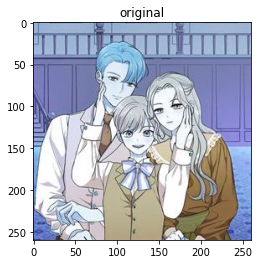

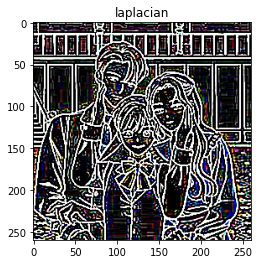

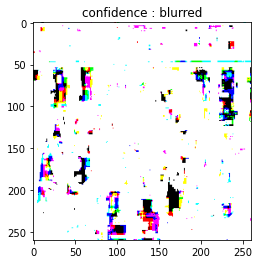

In [77]:
import cv2
import numpy as np
 
# 이미지 불러오기
img_orig_1 = cv2.imread(img_path_1, cv2.IMREAD_COLOR)
 
# 라플라시안 필터 적용
laplacian = cv2.Laplacian(img_orig_1, cv2.CV_8U, ksize=5)
 
# 라플라시안 필터 적용된 이미지에서, 각 값들의 제곱을 구함
dst = cv2.sqrBoxFilter(laplacian, ddepth=-1, ksize=(5,5), normalize=True)
 
# 분산을 구함 = 제곱의 평균 - 평균의 제곱
z = (dst - (laplacian*laplacian))
 
# blurred 처리되었다고 판단할 기준값 설정
 
threshold = 350
z[z<threshold] = 0
z[z>=threshold] = 1
 
# counting 0 and 1 (0 is blurred, 1 is ok)
blurred = z[z==0].shape[0]
normal = z[z==1].shape[0]
 
# blurred 처리된 영역의 비율 계산
confidence = normal / (blurred+normal)
 
print("confidence: " + str(confidence))
 
plt.title("original")
plt.imshow(img_orig_1)
plt.show()

plt.title("laplacian")
plt.imshow(laplacian)
plt.show()

plt.title("confidence : blurred")
plt.imshow(z)
plt.show()

cv2.waitKey()
cv2.destroyAllWindows()

#### 세그멘테이션으로 사람 분리하기

In [78]:
# 모델에 이미지를 입력
laplacian_path = '/content/drive/MyDrive/아이펠/풀잎스쿨/data/human_segmentation/images/라플라시안 필터.png'
segvalues, output = model.segmentAsPascalvoc(laplacian_path)

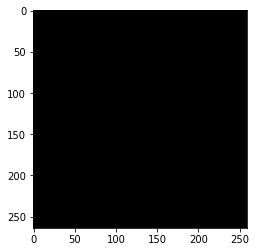

In [79]:
plt.imshow(output)
plt.show()

In [80]:
segvalues

{'class_ids': array([0]), 'masks': False}

In [81]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background


- 아무도 알아보질 못함.. 실패..

### 시도해 본 방법 2) 나만의 VOC 데이터셋 커스텀하기 
-> 말도안되는 노동이 필요했으므로 접음

### 시도해 본 방법 3) 그냥 포기하고 크로마키를 시도

In [82]:
img_path4 = '/content/drive/MyDrive/아이펠/풀잎스쿨/data/human_segmentation/images/교실.jpg' # 사진이 저장된 경로 
img_classroom = cv2.imread(img_path4) 
print (img_classroom.shape)

(557, 1024, 3)


In [90]:
target_size = img_orig2.shape[:2][::-1]
resized_classroom_image = cv2.resize(img_classroom, target_size)
print(resized_classroom_image.shape)

(855, 600, 3)


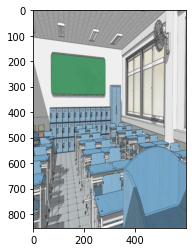

In [91]:
plt.imshow(resized_classroom_image)
plt.show()

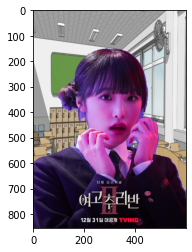

In [92]:
# img_concat = np.where(img_mask_color2==255, img_orig2, resized_classroom_image)
# plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
# plt.show()

# np.where(조건, 참일때, 거짓일때)
img_concat = np.where(img_mask_color2==255, img_orig2, resized_classroom_image)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 회고

## 이번 프로젝트에서 어려웠던 점

- 최근 DEEL ML 시간에 배운 `경계선 검출`, `스무딩`, `샤프닝`등의 필터들을 사용해서 효과적인 인물 검출을 해 보고 싶었으나, 이론과 실제 코딩은 많이 다른 것 같아서 조금 자신감을 잃었다...

## 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

### 1) 모델에 이미지가 입력되지 않는 문제

```
segvalues, output = model.segmentAsPascalvoc(img_path)
```
- 이 코드에서 `AttributeError: can't set attribute`라는 오류가 뜨면서 진행이 되지 않았다.
개인적인 호기심으로 인물이 그려진 웹툰 사진도 인식이 될까 궁금해서 넣었던 것이 잘못이었나 해서, 실제 인물 사진으로 바꿔보았지만 같은 오류가 뜸
- 모듈을 설치하고 나서 **런타임 재시작**을 하니 오류가 사라짐


### 2) 웹툰 캐릭터는 사람취급을 하지 않음

- 원본 이미지로 세그멘테이션을 했을 때, 세 명 중 한명을 온전히 인식해서, 조금 욕심을 내서 <u>**세 사람 모두** 사람으로 인식시키고 싶었다.</u>
- 금요일 DEEP ML 시간에 **`이미지 콘벌루션 연산과정`**에 대해서 배웠고, 마침 **`경계선 검출`**, **`스무딩`**, **`샤프닝`**에 대해서 이론적으로 설명을 들었기 때문에... 이론으로만 알지말고, <u>실제로 적용해 보고싶은 욕심이 생겼다.</u>
- 샤프닝으로 가장 많이 쓰인다는 <u>***라플라스 필터***</u>를 적용 시켜 보았으나.. 경계선을 확실히 만들어주긴 했으나, 세그멘테이션에서는 아무것도 인식하지 못하는 대참사가 일어났다.



### 3) segmentAsPascalvoc이 아닌, 웹툰데이터를 기반으로 만든 voc가 있을까 궁금해졌다.

검색을 하던 중에, 네이버에서 서비스하는 [웹툰 AI 페인터(WEBTOON AI Painter)](http://www.aitimes.kr/news/articleView.html?idxno=22901)라는 프로그램을 알게 되었다.

네이버 웹툰에서 3년간 빅데이터를 모아서 만든 채색도움 인공지능 서비스라고 하는데, 그렇다면 ***웹툰관련 voc(Visual Object Classes)가 존재하지 않을까?*** 하는 생각이 들었다.

그런데 존재하지 않는듯하여 <u>***VOC 데이터 셋***을 직접 커스텀</u> 해보기로 했다. -> 검색해보니, <u>training dataset을 전부 라벨링</u>을 해야하는 엄청난 작업이 기다리고있어서 ***포기***

<br>

**쏘카에서 차량 파손 탐지 딥러닝 모델 개발기**를 발견하여 흥미롭게 읽어보았다. <br>
(이 분들은 실제로 쏘카앱 이미지 2,000장을 라벨링하여 모델을 개발했다) 
- [Semantic Segmentation을 활용한 차량 파손 탐지 딥러닝 모델 개발기](https://tech.socarcorp.kr/data/2020/02/13/car-damage-segmentation-model.html#index1)

## 루브릭 평가 지표를 맞추기 위해 시도한 것들

|평가문항|상세기준|
|:------|:---|
|1. 인물모드 사진을 성공적으로 제작하였다.|아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.|
|2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.|인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.|
|3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.|추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.|

- 인물모드 사진과, 배경전환 크로마키를 성공적으로 완료
- 고양이를 안좋아해서 쿼카로 넣었더니 쿼카가 `bird`로 분류됨
- 웹툰 인물사진의 문제점을 제시했지만, 성공하지 못해서 찝찝하다.
- 솔루션(voc dataset 커스텀, crf 등)을 검색해 보았지만, 지금의 상황에서는 적용이 불가능해서 아쉽다. 많은 시간과 인력이 필요한 작업이라고 생각되었다.

## 만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정

    

- 동물에 딱히 관심이 없어서 고양이 사진을 시도해 보지 않음
- 쿼카가 `bird`로 분류됨
- 솔루션을 이용해서 문제점을 해결하지 못함.

## 자기 다짐

- opencv에는 원래도 관심이 많이 없었는데다 솔루션까지 실패하니 조금 우울하다.
- 그래도 DEEP ML에서 이론을 배워서 이것저것 해 보면 될 줄 알았는데, 찾아볼수록 너무 어려웠다. 
- 그래도 웹툰 관련으로는 VOC dataset을 만들어보는 것도 재밌을 것 같았다. <u>(네이버에서도 웹툰 사업에 진심인것 같다.)</u>